In [30]:
import numpy as np #用于处理和操作数组，特别是在处理图像数据时非常有用
import pandas as pd #用于处理和分析数据，可以方便地加载和操作数据集
import tensorflow as tf #用于构建和训练神经网络模型，提供了广泛的机器学习和深度学习功能
import cv2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split #用于将数据集划分为训练集和测试集，方便进行模型的训练和评估
from sklearn.metrics import accuracy_score #用于计算分类任务的准确率，可用于评估模型在测试集上的性能


In [31]:
data = pd.read_csv('fer2013.csv') #导入数据集

In [32]:
# 提取pixels和emotion并从矩阵转换成列表
pixels = data['pixels'].tolist()
emotion = data['emotion'].tolist()
usage=data['Usage'].tolist()

In [33]:
#将pixels转换为图像数组
images = np.array([np.fromstring(pixel, dtype='float32', sep=' ') for pixel in pixels])
images = images.reshape(-1, 48, 48, 1) # 将图像形状转换为 (样本数, 高度, 宽度, 通道数)
#在这种情况下，将图像形状转换为(样本数, 高度, 宽度, 通道数)中的通道数是1，表示图像是灰度图像，每个像素只有一个通道的灰度级别信息。


In [34]:
#tf.keras.utils.to_categorical 是 TensorFlow 中的一个实用函数，用于将整数标签转换为独热编码形式的向量。
#它将原始的整数标签转换为一个与类别数量相等的向量，其中对应类别的索引位置为1，其他位置为0。这样可以方便地表示每个图像的情绪类别。
emotion = tf.keras.utils.to_categorical(emotion)

In [35]:
# 划分训练集和测试集
train_images = []
train_emotion = []

test_images = []
test_emotion = []
for i in range(len(images)):
    if usage[i] == 'Training':
        #因为标签1的数量与其他的标签差距悬殊,故通过数据增强去增加其标签量
        if(emotion[i][1]==1):
            tmp=0
        else:
            tmp=6
        
        train_images.append(images[i])
        train_emotion.append(emotion[i])
        
        while(tmp<7):
            tmp+=1
             #随机对比度
            comp_images = tf.image.random_contrast(images[i], lower=0.8, upper=1.2)
            train_images.append(comp_images)
            train_emotion.append(emotion[i])
            
            #随机翻转并添加到新的列表
            flipped_images =tf.image.random_flip_left_right(comp_images,1)
            train_images.append(flipped_images)
            train_emotion.append(emotion[i])
           
            #随机亮度
            color_jittered_images = tf.image.random_brightness(images[i],max_delta=28)
            train_images.append(color_jittered_images)
            train_emotion.append(emotion[i])
    elif usage[i] == 'PublicTest' or usage[i] == 'PrivateTest':
        test_images.append(images[i])
        test_emotion.append(emotion[i])

print("train:"+str(len(train_images)))
print("test:"+str(len(test_images)))

train:122684
test:7178


In [36]:
# 将图像和标签转换为NumPy数组
train_images =np.array(train_images).astype(np.int32)
train_emotion = np.array(train_emotion)

test_images = np.array(test_images).astype(np.int32)
test_emotion = np.array(test_emotion)

In [38]:
#构建卷积神经网络模型
model = tf.keras.models.Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

#编译模型

learning_rate = 0.001
adam = tf.keras.optimizers.Adam(lr = learning_rate)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [39]:
# #部分参数
train_epochs=100
train_batchsize=64
savedir="DL/Save_model"

#训练模型和保存
history=model.fit(train_images, train_emotion, epochs=train_epochs, batch_size=train_batchsize, validation_data=(test_images, test_emotion))
#保存模型结构+权重数据

model.save('keras_model3.h5', save_format='tf')

# #模型加载
# # Recreate the exact same model
# new_model = tf.keras.models.load_model(savedir+'keras_model.h5')

Train on 122684 samples, validate on 7178 samples
Epoch 1/100


2023-06-11 23:15:49.128862: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-11 23:15:49.290023: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


122684/122684 [==============================] - 72s 585us/sample - loss: 1.9817 - accuracy: 0.2199 - val_loss: 1.8629 - val_accuracy: 0.2471
Epoch 2/100
122684/122684 [==============================] - 68s 555us/sample - loss: 1.8917 - accuracy: 0.2353 - val_loss: 1.8599 - val_accuracy: 0.2471
Epoch 3/100
122684/122684 [==============================] - 68s 552us/sample - loss: 1.7483 - accuracy: 0.3058 - val_loss: 1.5221 - val_accuracy: 0.4025
Epoch 4/100
122684/122684 [==============================] - 68s 557us/sample - loss: 1.5666 - accuracy: 0.3813 - val_loss: 1.4589 - val_accuracy: 0.4206
Epoch 5/100
122684/122684 [==============================] - 68s 555us/sample - loss: 1.4350 - accuracy: 0.4378 - val_loss: 1.3403 - val_accuracy: 0.4698
Epoch 6/100
122684/122684 [==============================] - 68s 555us/sample - loss: 1.2896 - accuracy: 0.5044 - val_loss: 1.2586 - val_accuracy: 0.5124
Epoch 7/100
122684/122684 [==============================] - 68s 552us/sample - loss: 1.

In [40]:
#进行预测并评估准确率
y_pred = model.predict(test_images)


y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(test_emotion, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print("准确率:", accuracy)

# 加载标签映射关系
label_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


准确率: 0.649902479799387


In [64]:
y_psum=[[0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0]]
y_sum=[0,0,0,0,0,0,0]
print(y_pred)
print(y_true_labels[2])
for y in range(len(y_pred)):
    y_psum[y_true_labels[y]]+=y_pred[y]
    y_sum[y_true_labels[y]]+=1
print(len(y_psum))
print(y_sum)

for i in range(len(y_psum)):
    x=0
    for j in range(7):
        x+=y_psum[i][j]
    for k in range(7):
        y_psum[i][k]/=x
        y_psum[i][k]*=100
for i in range(len(y_psum)):
    y_psum[i]=list(y_psum[i])
print(y_psum)

[[5.71697116e-01 1.29294517e-02 5.49281761e-02 ... 3.02614987e-01
  7.13392673e-03 3.12219094e-02]
 [2.34974862e-09 1.00000000e+00 6.99044655e-10 ... 5.51194615e-13
  7.68021240e-14 1.57838438e-15]
 [9.99971867e-01 1.53930983e-11 2.74321428e-05 ... 2.44092860e-07
  5.88950861e-08 2.99323375e-07]
 ...
 [5.77749014e-02 1.27682928e-03 4.24994752e-02 ... 1.21922664e-01
  1.03536798e-02 7.46600211e-01]
 [3.72806787e-02 1.58636842e-03 6.48853555e-02 ... 8.20772767e-01
  7.30085606e-03 5.16754985e-02]
 [2.37173270e-02 5.24230127e-04 3.56112927e-01 ... 5.94317377e-01
  7.73040159e-03 1.39922891e-02]]
4
7
[958, 111, 1024, 1774, 1247, 831, 1233]
[[50.74075051038858, 2.4222770622292127, 12.275527558984896, 4.660878120922247, 13.032585753377585, 2.387599072845267, 14.480381921252228], [11.721039851705902, 70.85325666467371, 3.5013158038471754, 3.623460026391926, 5.12107403587915, 1.1094503022495796, 4.070403315252558], [10.388090801667127, 0.9645692366964345, 45.739540716104464, 3.008882326370605,

In [41]:
# 获取图像并进行预测
def predict_emotion(image):
    # 将图像调整为模型所需的大小
    image = cv2.resize(image, (48, 48))
    # 转换为灰度图像
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 将图像转换为模型所需的形状
    input_image = np.expand_dims(gray, axis=-1)
    input_image = np.expand_dims(input_image, axis=0)
    # 预测图像的情绪
    predictions = model.predict(input_image)
    # 获取预测结果的索引
    pred_index = np.argmax(predictions[0])
    # 获取预测结果的标签
    emotion_label = label_mapping[pred_index]
    return emotion_label

# 获取图像并进行预测
def get_and_predict_emotion(image_path):
    # 读取图像
    image = cv2.imread(image_path)
    predicted_emotion = predict_emotion(image)
    return predicted_emotion

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


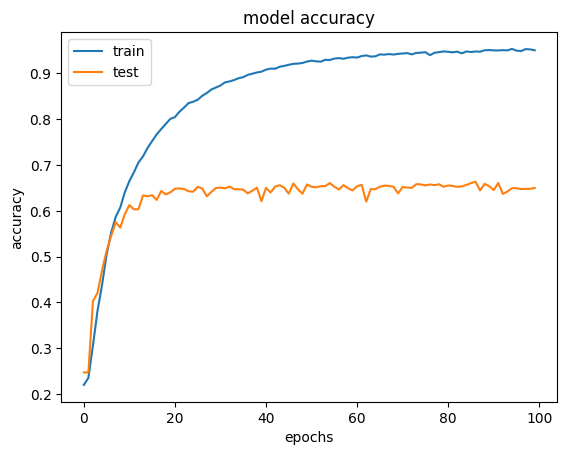

In [42]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','test'], loc='upper left')
plt.savefig('train_validation_acc.png')


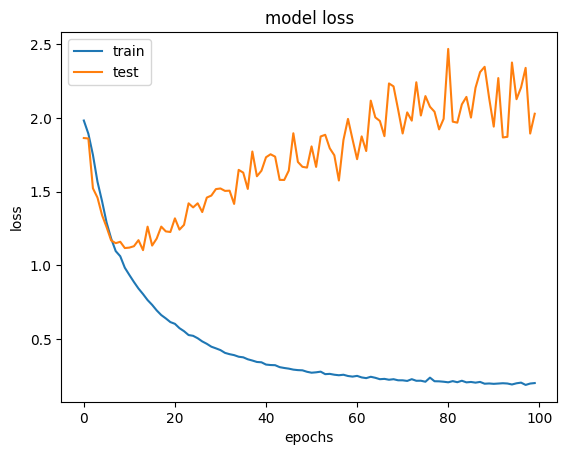

In [43]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('train_validation_loss.png')

In [44]:
# 测试图像
test_image_path = 'predict.jpg'
predicted_emotion = get_and_predict_emotion(test_image_path)
print('Predicted Emotion:', predicted_emotion)

Predicted Emotion: Angry


Normalized confusion matrix
0.5074075051038858	0.02422277062229212	0.12275527558984894	0.04660878120922246	0.13032585753377585	0.023875990728452666	0.14480381921252225
0.11721039851705901	0.708532566646737	0.035013158038471756	0.03623460026391926	0.0512107403587915	0.011094503022495796	0.04070403315252558
0.10388090801667128	0.009645692366964345	0.4573954071610447	0.030088823263706054	0.17526563122055222	0.07511231134842918	0.14861122662263232
0.02310556842154045	0.002340799813772391	0.02356144647788848	0.8191664557783881	0.03362154353765209	0.024407486035909098	0.0737966999348496
0.10163470462008821	0.010222481699448173	0.12609004038049618	0.048173985672874675	0.4737335587728633	0.02018727314086701	0.21995795571336252
0.02698041810359304	0.0031256089476431616	0.08709701935571462	0.03423662079489291	0.025028091803032785	0.7774190560539401	0.04611318494118336
0.05708551180939415	0.005176897684939905	0.05586752165720552	0.06818963456403145	0.15746518087492342	0.01696383610938608	0.639251

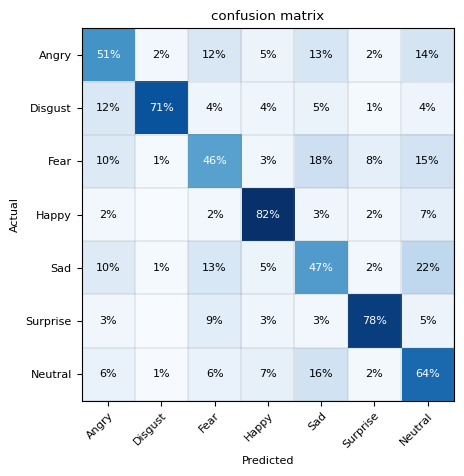

In [68]:
#混淆矩阵
def plot_Matrix(cm, classes, title=None,  cmap=plt.cm.Blues):
    plt.rc('font',family='Times New Roman',size='8')   # 设置字体样式、大小
    
    # 按行进行归一化
    
    cm = np.array(cm).astype('float') / np.array(cm).sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    str_cm = cm.astype(np.str).tolist()
    for row in str_cm:
        print('\t'.join(row))
    # 占比1%以下的单元格，设为0，防止在最后的颜色中体现出来
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if int(cm[i, j]*100 + 0.5) == 0:
                cm[i, j]=0

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax) # 侧边的颜色条带
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # 通过绘制格网，模拟每个单元格的边框
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.2)
    ax.tick_params(which="minor", bottom=False, left=False)

    # 将x轴上的lables旋转45度
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # 标注百分比信息
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if int(cm[i, j]*100 + 0.5) > 0:
                ax.text(j, i, format(int(cm[i, j]*100 + 0.5) , fmt) + '%',
                        ha="center", va="center",
                        color="white"  if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('cm.jpg', dpi=300)
    plt.show()
label1 = ['Angry' ,'Disgust',  'Fear',  'Happy', 'Sad',  'Surprise',  'Neutral']
plot_Matrix(y_psum,label1,"confusion matrix")